Sports Info Solutions analytics challenge: https://github.com/ecavan/AnalyticsChallenge2021

Q: Which route combinations were most popular in the NFL in 2020? Of these route combinations, which perform best against each coverage type?

# Imports & Data

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import copy

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
from collections import Counter

import category_encoders as ce

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, balanced_accuracy_score, mean_absolute_error
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

In [3]:
plays = pd.read_csv('PlayByPlay.csv')
games = pd.read_csv('GameInfo.csv')
games = games.drop(['Week', 'Season'], axis=1)
points = pd.read_csv('PlayerTotalPoints.csv')
points=points.rename(columns = {'Name':'Name_points'})
skillpos = pd.read_csv('SkillPositionPlayers.csv')
tms = pd.read_csv('tms.csv')
rates = pd.read_csv('M21 Launch Ratings - Sheet1.csv')
rates = rates[['Name', 'archetype', 'overall_rating']]

print(rates.columns)
print(len(rates))
print(plays.columns)
print(len(plays))
print(' ')
print(games.columns)
print(len(games))
print(' ')
print(points.columns)
print(len(points))
print(' ')
print(skillpos.columns)
print(len(skillpos))
print(' ')
### from: https://www.pro-football-reference.com/years/2020/index.htm ###

print(tms.columns)

Index(['Name', 'archetype', 'overall_rating'], dtype='object')
2293
Index(['GameID', 'EventID', 'Season', 'Week', 'OffensiveTeam', 'DefensiveTeam',
       'OffTeamScoreBefore', 'DefTeamScoreBefore', 'Quarter', 'TimeLeft',
       'Down', 'ToGo', 'SideOfField', 'StartYard', 'Hash', 'EventType',
       'FirstDown', 'Touchdown', 'Safety', 'Turnover', 'Attempt', 'Completion',
       'Spike', 'ThrowAway', 'ThrowDepth', 'Shotgun', 'DropType', 'RPO',
       'CoverageScheme', 'PressureOnPlay', 'SackOnPlay', 'PassBreakupOnPlay',
       'InterceptionOnPlay', 'FumbleByPasser', 'FumbleByRusher',
       'FumbleByReceiver', 'OffensiveYardage', 'EPA', 'PlayDesc'],
      dtype='object')
32170
 
Index(['GameId', 'HomeTeamId', 'HomeTeam', 'AwayTeamId', 'AwayTeam',
       'StadiumName', 'CoveredStadium', 'HomeScore', 'AwayScore', 'SpreadLine',
       'TotalLine', 'SpreadResult', 'TotalResult', 'Weather',
       'PrecipIntensity', 'PrecipProbability', 'PrecipType', 'Temperature',
       'WindSpeed'],
     

In [4]:
plays_games = plays.merge(games, left_on = 'GameID', right_on = 'GameId')
plays_games_points = plays_games.merge(points, on = 'GameID')
full_df = plays_games_points.merge(skillpos, on = ['GameID', 'PlayerId', 'EventID'])
full_df = full_df.merge(tms, left_on = 'OffensiveTeam', right_on = 'Tm')
full_df = full_df.merge(rates, on ='Name', how = 'left')

# Feature Engineering

In [5]:
full_df.loc[full_df['Target'] == 1, 'air_yards'] = full_df['ThrowDepth']

full_df['AYPA'] = full_df['air_yards']/full_df['Attempt']
full_df['YPA'] = full_df['OffensiveYardage']/full_df['Attempt']

full_df.loc[(full_df['SideOfField'] == 'Own')&(full_df['StartYard'] < 20), 'FieldPosition'] = 'EZ'
full_df.loc[(full_df['SideOfField'] == 'Oppo')&(full_df['StartYard'] < 20), 'FieldPosition'] = 'RZ'
full_df.loc[(full_df['StartYard'] > 20), 'FieldPosition'] = 'Mid'

full_df_target = full_df[full_df.Target ==  1]
full_df_target = full_df_target[full_df_target.groupby('Route')['Route'].transform('size') > 39]

gb_routes = full_df_target.groupby('Route', dropna=False)['air_yards'].mean().reset_index()
kmeans = KMeans(n_clusters=3)
kmeans.fit(gb_routes['air_yards'].values.reshape(-1,1))
y_kmeans = kmeans.predict(gb_routes['air_yards'].values.reshape(-1,1))

long = gb_routes[gb_routes.air_yards > 20]['Route'].to_list()
medium = gb_routes[(gb_routes.air_yards < 20) & (gb_routes.air_yards >= 10)]['Route'].to_list()
short = gb_routes[(gb_routes.air_yards < 10) & (gb_routes.air_yards >= -0.5)]['Route'].to_list()
screen = gb_routes[gb_routes.air_yards < -0.5]['Route'].to_list()
rpo = full_df[(full_df.RPO == 1)&(full_df.Target == 1)].index.to_list()

full_df.loc[full_df['Route'].isin(long), 'route_len'] = 'Long'
full_df.loc[full_df['Route'].isin(medium), 'route_len'] = 'Medium'
full_df.loc[full_df['Route'].isin(short), 'route_len'] = 'Short'
full_df.loc[full_df['Route'].isin(screen), 'route_len'] = 'Screen'
full_df.loc[full_df.index.isin(rpo), 'Route'] = 'rpo'

rpo_list = full_df[full_df.Route == 'rpo']['Route'].to_list()

Kmeans plot of all routes clustered into classes: long, medium, short and screen routes (this is done to easily distinguish between the variety of routes available). I will use the classes of routes for key calculations and then refer to the routes that are best in their given class (i.e the best short routes, the best medium routes, ect) to make predictions using the machine learning models (Expected points, probability of a first down). 

Note: I used 3 clusters, but took any routes with air yards < -0.5 to be considered screens.

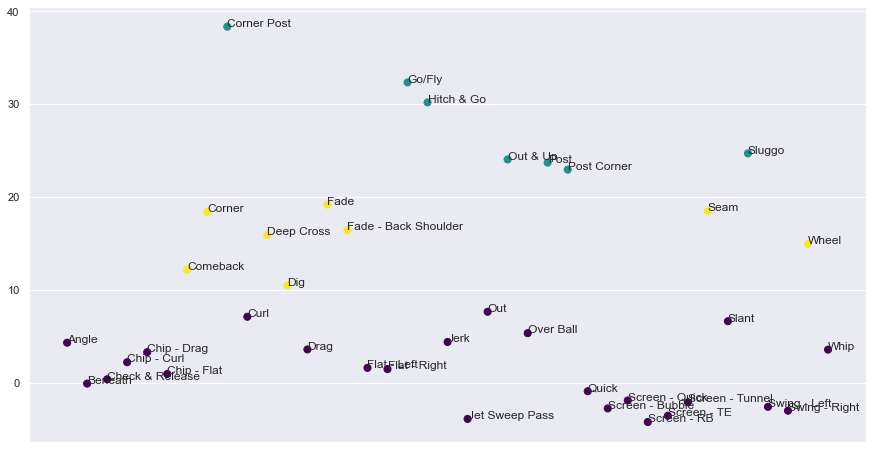

In [6]:
plt.rcParams["figure.figsize"] = (15,8)
plt.scatter(gb_routes['Route'], gb_routes['air_yards'], c=y_kmeans, s=50, cmap='viridis')
plt.xticks([]);

for i, txt in enumerate(gb_routes['Route']):
    plt.annotate(txt, (gb_routes['Route'][i], gb_routes['air_yards'][i]))   

In [7]:
full_df_catch = full_df[full_df.Completion == 1]
full_df['YAC'] = full_df_catch.OffensiveYardage - full_df_catch.ThrowDepth

full_df['YAC_per_cov'] = full_df.groupby('CoverageScheme', dropna=False)['YAC'].transform('mean')

pressure_df = (full_df.groupby(['CoverageScheme', 'DefensiveTeam'])['PressureOnPlay'].sum()/full_df.groupby('DefensiveTeam')['CoverageScheme'].size()).reset_index(name = 'pressure_rate_per_coverage')
breakup_df = ((full_df.groupby(['CoverageScheme', 'DefensiveTeam'])['PassBreakupOnPlay'].sum() + full_df.groupby(['CoverageScheme', 'DefensiveTeam'])['ThrowAway'].sum() )/full_df.groupby('DefensiveTeam')['CoverageScheme'].size()).reset_index(name = 'breakup_rate_per_coverage')
target_df = (full_df.groupby(['CoverageScheme', 'DefensiveTeam'])['Target'].sum()/full_df.groupby('DefensiveTeam')['CoverageScheme'].size()).reset_index(name = 'target_rate_per_coverage')
fd_df = (full_df.groupby(['CoverageScheme', 'DefensiveTeam'])['FirstDown'].sum()/full_df.groupby('DefensiveTeam')['CoverageScheme'].size()).reset_index(name = 'firstdown_rate_per_coverage')

fm_df = (full_df.groupby(['OffensiveTeam'])['FastMotion'].sum()/full_df.groupby('OffensiveTeam')['CoverageScheme'].size()).reset_index(name = 'motion_rate_per_coverage')

full_df = full_df.merge(breakup_df, on = ['CoverageScheme', 'DefensiveTeam'])
full_df = full_df.merge(pressure_df, on = ['CoverageScheme', 'DefensiveTeam'])
full_df = full_df.merge(target_df, on = ['CoverageScheme', 'DefensiveTeam'])
full_df = full_df.merge(fd_df, on = ['CoverageScheme', 'DefensiveTeam'])
full_df = full_df.merge(fm_df, on = 'OffensiveTeam')

Obviously having a greater QB throwing the ball or having a better receiver on the end of that throw matters. I used the Total_Points feature from SIS to create a meature which determines how much better a player like Tom Brady is compared to the average QB (Points above Average, instead of Points above replacement, since I had no idea how a replacement level QB should preform). I didn't include players with less than 300 snaps so that they would not influence the calculation of the mean. 

In [8]:
snaps = full_df.groupby(['RosterPosition', 'Name'])['Name'].size().reset_index(name = 'snaps')
full_df = full_df.merge(snaps, on =['RosterPosition', 'Name'])
full_df = full_df[full_df.snaps > 50]

full_df['Average_points'] = full_df.groupby('RosterPosition')['TotalPoints'].transform('mean')
full_df['PAA'] = (full_df.groupby('Name')['TotalPoints'].transform('mean') - full_df['Average_points'])/full_df['Average_points']


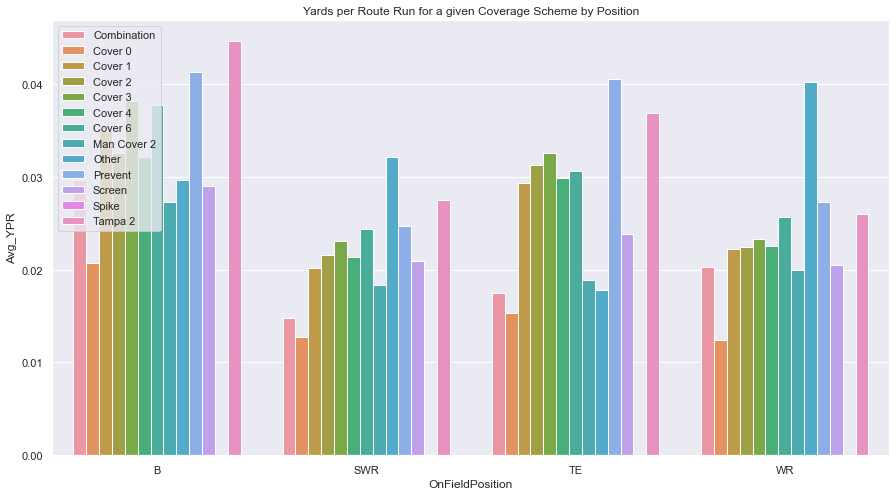

In [9]:
full_df['Yards_per_route'] = full_df['OffensiveYardage']/full_df['snaps']
full_df_noqb = full_df[full_df.OnFieldPosition != 'QB']
gb = (full_df_noqb.groupby(['OnFieldPosition', "CoverageScheme" ])['air_yards'].sum()/full_df_noqb.groupby(['OnFieldPosition', "CoverageScheme" ])['Attempt'].sum()).reset_index(name = 'APA')

gb_ybr = full_df_noqb.groupby(['OnFieldPosition', "CoverageScheme" ])['Yards_per_route'].mean().reset_index(name = 'Avg_YPR')

sns.barplot(x='OnFieldPosition', y='Avg_YPR', hue="CoverageScheme", data=gb_ybr);
plt.title('Yards per Route Run for a given Coverage Scheme by Position');
plt.legend(loc='upper left');

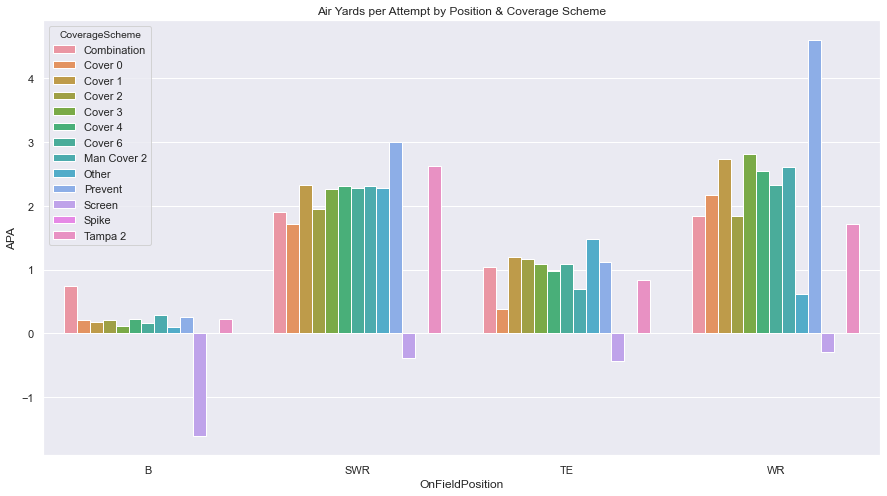

In [10]:
sns.barplot(x='OnFieldPosition', y='APA', hue = "CoverageScheme", data=gb);
plt.title('Air Yards per Attempt by Position & Coverage Scheme');

Sample of High Preforming QBs
 
['Deshaun Watson' 'Matt Ryan' 'Josh Allen' 'Derek Carr'
 'Teddy Bridgewater' 'Justin Herbert' 'Drew Brees' 'Tom Brady'
 'Patrick Mahomes' 'Philip Rivers' 'Joe Burrow' 'Ryan Tannehill'
 'Russell Wilson' 'Matthew Stafford' 'Aaron Rodgers' 'Kirk Cousins'
 'Kyler Murray']
 
Top QBs in Madden
 
                  Name RosterPosition  overall_rating
48292  Patrick Mahomes             QB            99.0
89466   Russell Wilson             QB            97.0
8240     Lamar Jackson             QB            94.0
37312       Drew Brees             QB            93.0
41892        Tom Brady             QB            90.0


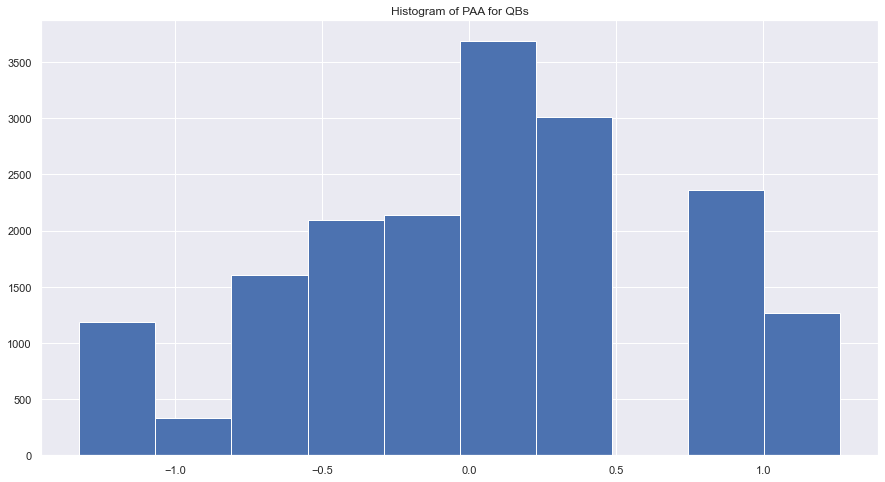

Sample of High Preforming WRs
 
['Calvin Ridley' 'Julio Jones' 'Stefon Diggs' 'Cole Beasley'
 'Keenan Allen' 'Michael Thomas' 'Tyreek Hill' 'Jarvis Landry'
 'Corey Davis' 'Davante Adams' 'Justin Jefferson' 'Brandon Aiyuk'
 'DeAndre Hopkins' 'Cooper Kupp']
 
Top WRs in Madden
 
                   Name RosterPosition  overall_rating
39966    Michael Thomas             WR            99.0
111101  DeAndre Hopkins             WR            98.0
7631        Julio Jones             WR            97.0
49192       Tyreek Hill             WR            96.0
101691    Davante Adams             WR            94.0


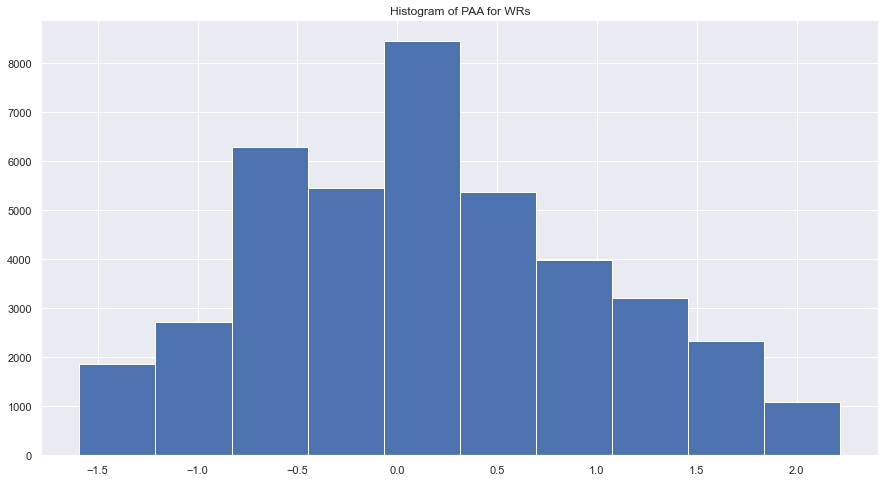

In [11]:
###sample players###
full_df_wr = full_df[(full_df.RosterPosition == 'WR')&(full_df.snaps > 250)]
full_df_qb = full_df[(full_df.RosterPosition == 'QB')&(full_df.snaps > 250)]

madden_df = pd.DataFrame(full_df.sort_values('overall_rating', ascending = False))
madden_df = madden_df[['Name', 'RosterPosition','overall_rating']]
madden_df.drop_duplicates(keep = 'first', inplace=True)

print('Sample of High Preforming QBs')
print(' ')
print(full_df_qb[full_df_qb.PAA > 0]['Name'].unique())
print(' ')
madden_df_qb = madden_df[madden_df.RosterPosition == 'QB']
print('Top QBs in Madden')
print(' ')
print(madden_df_qb[0:5])

plt.hist(full_df_qb['PAA']);
plt.title('Histogram of PAA for QBs')
plt.show()

print('Sample of High Preforming WRs')
print(' ')
print(full_df_wr[full_df_wr.PAA > 1]['Name'].unique())
print( ' ')
madden_df_wr = madden_df[madden_df.RosterPosition == 'WR']
print('Top WRs in Madden')
print(' ')
print(madden_df_wr[0:5])

plt.hist(full_df_wr['PAA']);
plt.title('Histogram of PAA for WRs')
plt.show()

Next, I wanted to classify players based on their specialities with the routes they run. i.e a player like Tyreek Hill would have a speciality as a player who is exceptional at running 'Long' routes like Streaks and Corner Post routes. The best receivers (like Tyreek Hill) may be classified as a specialist with multipe route types. The idea is if you are a specialist as a short route receiver, you are worth more running a short route compared to a long route.

In [12]:
player_type = full_df.groupby(['Name', 'route_len'])['EPA'].agg(['mean', 'count']).reset_index()

mean_len_long = np.mean(player_type[player_type.route_len == 'Long']['count'])
mean_len_med = np.mean(player_type[player_type.route_len == 'Medium']['count'])
mean_len_short = np.mean(player_type[player_type.route_len == 'Short']['count'])
mean_len_screen = np.mean(player_type[player_type.route_len == 'Screen']['count'])

mean_epa_long = np.mean(player_type[player_type.route_len == 'Long']['mean'])
mean_epa_med = np.mean(player_type[player_type.route_len == 'Medium']['mean'])
mean_epa_short = np.mean(player_type[player_type.route_len == 'Short']['mean'])
mean_epa_screen = np.mean(player_type[player_type.route_len == 'Screen']['mean'])

player_type['Classify'] = np.nan

player_type.loc[(player_type.route_len == 'Long')&(player_type['mean'] >= 1.5*mean_epa_long)&(player_type['count'] >= 1.2*mean_len_long), 'Classify'] = 'Long'
player_type.loc[(player_type.route_len == 'Short')&(player_type['mean'] >= 1.5*mean_epa_short)&(player_type['count'] >= 1.2*mean_len_short), 'Classify'] = 'Short'
player_type.loc[(player_type.route_len == 'Medium')&(player_type['mean'] >= 1.5*mean_epa_med)&(player_type['count'] >= 1.2*mean_len_med), 'Classify'] = 'Medium'
player_type.loc[(player_type.route_len == 'Screen')&(player_type['mean'] >= 1.5*mean_epa_screen)&(player_type['count'] >= 1.2*mean_len_screen), 'Classify'] = 'Screen'

player_type = player_type.dropna()
gb = player_type.groupby('Name')['Classify'].unique().reset_index(name = 'receiver_class')

full_df = full_df.merge(gb, on = 'Name', how = 'left')
full_df['receiver_class'] = full_df['receiver_class'].fillna('None')

##A bool which determines if a player (or multiple players) are running a specialized route on the play##
full_df['Running_specialized_route'] = full_df.apply(lambda x: str(x['route_len']) in x['receiver_class'], axis=1)


Are slot receivers better than wideouts for certain schemes?

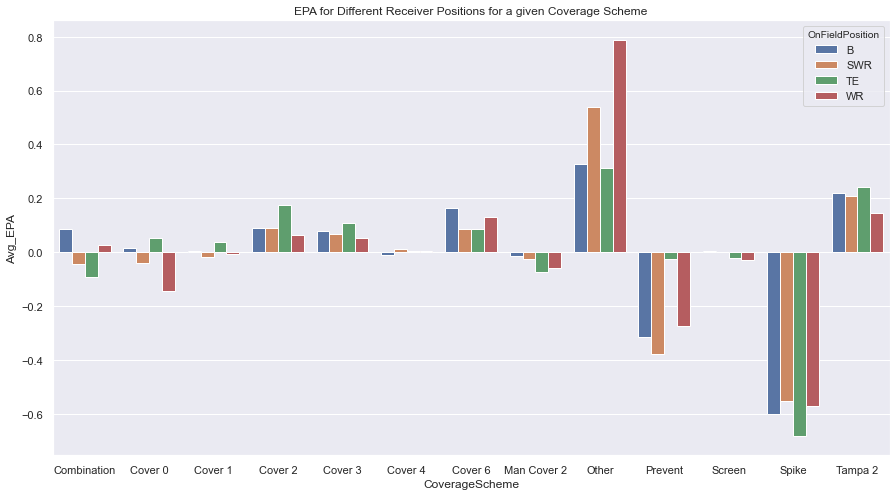

In [13]:
gb_pos = full_df_noqb.groupby(['CoverageScheme','OnFieldPosition' ])['EPA'].mean().reset_index(name = 'Avg_EPA')

sns.barplot(x="CoverageScheme", y='Avg_EPA', hue='OnFieldPosition', data=gb_pos);
plt.title('EPA for Different Receiver Positions for a given Coverage Scheme');

# Most Popular Route Combinations

The first part of the question asks what are the most popular route combinations, we answer this questiom in the following cells.

In [14]:
pos_df = full_df.groupby(['GameID', 'EventID'])['OnFieldPosition'].apply(list).reset_index()
pos_df.columns = ['GameID', 'EventID', 'position']

full_df = full_df.merge(pos_df, on =['GameID', 'EventID'])
full_df['position'] = full_df['position'].sort_values().apply(lambda x: sorted(x))

lst = list(full_df['position'])
full_df['position'] = full_df['position'].astype(str)

full_df.loc[((full_df.position == "['B', 'QB', 'SWR', 'SWR', 'WR', 'WR']")|(full_df.position == "['B', 'QB', 'SWR', 'SWR', 'SWR', 'WR']")|(full_df.position == "['B', 'QB', 'SWR', 'SWR', 'SWR', 'SWR']")), 'Personnel'] = '10'
full_df.loc[((full_df.position == "['B', 'QB', 'SWR', 'SWR', 'TE', 'WR']")|(full_df.position == "['B', 'QB', 'SWR', 'SWR', 'SWR', 'TE']")|(full_df.position == "['B', 'QB', 'SWR', 'SWR', 'TE', 'WR']")), 'Personnel'] = '11'
full_df.loc[((full_df.position == "['B', 'QB', 'SWR', 'TE', 'TE', 'WR']")|(full_df.position == "['B', 'QB', 'SWR', 'SWR', 'TE', 'TE']")|(full_df.position == "['B', 'QB', 'TE', 'TE', 'WR', 'WR']")), 'Personnel'] = '12'
full_df.loc[((full_df.position == "['B', 'B', 'QB', 'SWR', 'TE', 'WR']")|(full_df.position == "['B', 'B', 'QB', 'SWR', 'SWR', 'TE']")), 'Personnel'] = '21'
c = Counter(map(tuple,lst))

per_counted = [(l,k/len(l)) for k,l in sorted([(j,i) for i,j in c.items()], reverse=True)]
per_counted[0:5]

[(('B', 'QB', 'SWR', 'SWR', 'WR', 'WR'), 2867.0),
 (('B', 'QB', 'SWR', 'SWR', 'TE', 'WR'), 1894.0),
 (('B', 'QB', 'SWR', 'TE', 'WR', 'WR'), 1856.0),
 (('B', 'QB', 'SWR', 'SWR', 'SWR', 'WR'), 1733.0),
 (('QB', 'SWR', 'SWR', 'SWR', 'WR', 'WR'), 1185.0)]

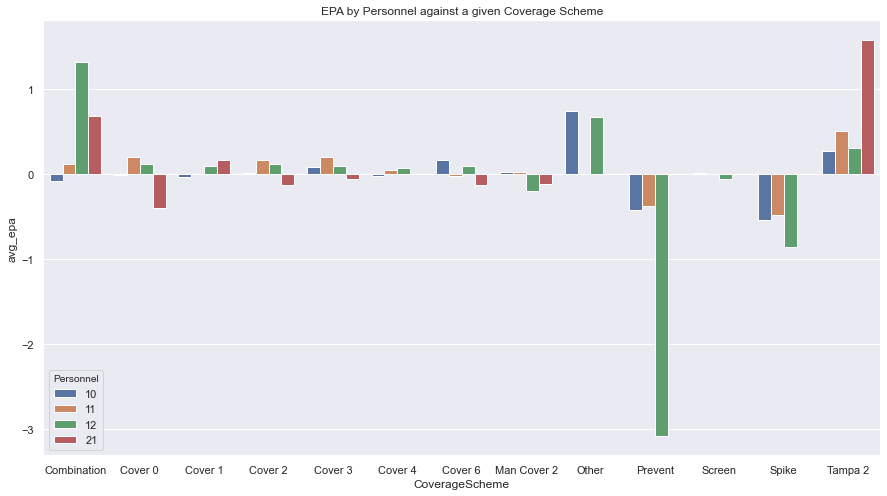

In [15]:
gb_p = full_df.groupby(['Personnel', "CoverageScheme"])['EPA'].mean().reset_index(name = 'avg_epa')

sns.barplot(x="CoverageScheme", y='avg_epa', hue='Personnel', data=gb_p);
plt.title('EPA by Personnel against a given Coverage Scheme');

In [16]:
full_df['Route'] = full_df['Route'].fillna('Blocking')

full_df_with_block = full_df.copy()
full_df = full_df[full_df['Route'] != 'Blocking']

route_df = full_df.groupby(['GameID', 'EventID'])['Route'].apply(list).reset_index()
route_df.columns = ['GameID', 'EventID', 'Route_list']

full_df = full_df.merge(route_df, on =['GameID', 'EventID'])

In [17]:
df_p10 = full_df[full_df.Personnel == '10']
df_p11 = full_df[full_df.Personnel == '11']
df_p12 = full_df[full_df.Personnel == '12']
df_p21 = full_df[full_df.Personnel == '21']

p10_lst = df_p10['Route_list']

print('Most Common Routes 10 personnel')
print(Counter(tuple(item) for item in p10_lst).most_common(5))
print(' ')
print('Least Common Routes 10 personnel')
print(Counter(tuple(item) for item in p10_lst).most_common()[-5:-1])

p11_lst = df_p11['Route_list']
print('----------------------------------------------------------------------------------------------------------- ')
print(' ')
print('Most Common Routes 11 personnel')
print(Counter(tuple(item) for item in p11_lst).most_common(5))
print(' ')
print('Least Common Routes 11 personnel')
print(Counter(tuple(item) for item in p11_lst).most_common()[-5:-1])
print('------------------------------------------------------------------------------------------------------------ ')
print(' ')

p12_lst = df_p12['Route_list']

print('Most Common Routes 12 personnel')
print(Counter(tuple(item) for item in p12_lst).most_common(5))
print(' ')
print('Least Common Routes 12 personnel')
print(Counter(tuple(item) for item in p12_lst).most_common()[-5:-1])

print('------------------------------------------------------------------------------------------------------------ ')
print(' ')

p21_lst = df_p21['Route_list']

print('Most Common Routes 21 personnel')
print(Counter(tuple(item) for item in p21_lst).most_common(5))
print(' ')
print('Least Common Routes 21 personnel')
print(Counter(tuple(item) for item in p21_lst).most_common()[-5:-1])

Most Common Routes 10 personnel
[(('Run Fake', 'rpo'), 48), (('Curl', 'Curl', 'Curl', 'Curl'), 36), (('rpo', 'Run Fake'), 36), (('Curl', 'Curl', 'Curl', 'Curl', 'Curl'), 35), (('Screen - RB',), 24)]
 
Least Common Routes 10 personnel
[(('Go/Fly', 'Screen - RB'), 2), (('Screen - Shovel',), 1), (('rpo',), 1), (('Fade',), 1)]
----------------------------------------------------------------------------------------------------------- 
 
Most Common Routes 11 personnel
[(('rpo', 'Run Fake'), 70), (('Run Fake', 'rpo'), 44), (('Jet Sweep Pass',), 18), (('Run Fake', 'Screen - Tunnel'), 16), (('Out', 'Out', 'Curl', 'Out', 'Curl'), 15)]
 
Least Common Routes 11 personnel
[(('Swing - Right', 'Screen - RB'), 2), (('Go/Fly', 'Screen - TE'), 2), (('Screen - Tunnel', 'Flat - Right'), 2), (('Screen - Drag',), 1)]
------------------------------------------------------------------------------------------------------------ 
 
Most Common Routes 12 personnel
[(('rpo', 'Run Fake'), 44), (('Run Fake', 'rpo')

Because there are so many combinations of possible routes, I chose to look at the combinations of route lengths; and then pick the best routes to replace the route lengths (i.e chose curl to replace a short route since it has the highest EPA for all short routes).

In [18]:
route_list = full_df['Route_list'].tolist()

route_list2 = copy.deepcopy(route_list)

for i, x in enumerate(route_list2):
    for j, a in enumerate(x):
        if a in short:
            route_list2[i][j] = 'short'
        elif a in long:
            route_list2[i][j] = 'long'
        elif a in medium:
            route_list2[i][j] = 'medium'
        elif a in screen:
            route_list2[i][j] = 'screen'
        elif a in rpo_list:
            route_list2[i][j] = 'rpo'

route_list_sort = []
for i in route_list2:
    route_list_sort.append(sorted(i))
    
c = Counter(map(tuple,route_list_sort))

routes_counted = [(l,k/len(l)) for k,l in sorted([(j,i) for i,j in c.items()], reverse=True)]

full_df['Route_list'] = full_df['Route_list'].sort_values().apply(lambda x: sorted(x))

print('Most popular route combinations by route length: ')
print('')
print(routes_counted[0:10])

full_df.insert(104, 'route_len_list', route_list_sort)
full_df['route_len_list' ] = full_df['route_len_list' ].astype(str)
full_df['Route_list' ] = full_df['Route_list' ].astype(str)

Most popular route combinations by route length: 

[(('medium', 'medium', 'short', 'short', 'short'), 1226.0), (('medium', 'short', 'short', 'short', 'short'), 944.0), (('long', 'medium', 'short', 'short', 'short'), 812.0), (('long', 'medium', 'medium', 'short', 'short'), 800.0), (('short', 'short', 'short', 'short', 'short'), 749.0), (('medium', 'medium', 'medium', 'short', 'short'), 652.0), (('medium', 'medium', 'short', 'short'), 688.0), (('medium', 'short', 'short', 'short'), 640.0), (('long', 'medium', 'short', 'short'), 532.0), (('long', 'short', 'short', 'short', 'short'), 372.0)]


Count encode features for the Machine Learning Models

In [19]:
cat_features = ['route_len', 'Route', 'RosterPosition', 'DropType', 'archetype','route_len_list', 'Route_list'  ]

count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(full_df[cat_features])
full_df = full_df.join(count_encoded.add_suffix("_count"))

Create coverage dictionary (a dictionary which partions full_df by coverage scheme)

In [20]:
full_df = full_df[(full_df.CoverageScheme !='Spike')&(full_df.CoverageScheme != 'Other') ]
full_df[['PressureOnPlay']] = full_df[['PressureOnPlay']].fillna(value=0)
full_df[['ThrowDepth']] = full_df[['ThrowDepth']].fillna(value=np.mean(full_df.ThrowDepth))

cov_dict = dict(tuple(full_df.groupby('CoverageScheme')))

epa_dict = {}

for k,v in cov_dict.items():
    gb = v.groupby(['route_len_list', 'Personnel'])['EPA'].agg(['mean', 'count']).reset_index().sort_values(by = 'mean', ascending = False)
    epa_dict[k] = gb[gb['count'] > 0.5*np.mean(gb['count'])]
    
epa_dict2 = {}

for k,v in cov_dict.items():
    gb = v.groupby(['Route', 'route_len', 'Personnel'])['EPA'].agg(['mean', 'count']).reset_index().sort_values(by = 'mean', ascending = False)
    epa_dict2[k] = gb[gb['count'] > 0.5*np.mean(gb['count'])]

Below we print the top 3 best route combinations, route length combinations and routes for each coverage Scheme.

In [21]:
epa_dict3 = {}

for k,v in cov_dict.items():
    gb = v.groupby(['Route_list', 'Personnel'])['EPA'].agg(['mean', 'count']).reset_index().sort_values(by = 'mean', ascending = False)
    epa_dict3[k] = gb[gb['count'] > 0.5*np.mean(gb['count'])]
    
    
for k,v in epa_dict3.items():
    print('Best Route combinations by EPA for: ' + k)
    print(' ')
    print(v.head(3))
    print(' ')    

Best Route combinations by EPA for: Combination
 
                                         Route_list Personnel      mean  count
0   ['Angle', 'Chip - Flat', 'Curl', 'Dig', 'Drag']        12  3.223762      5
17         ['Corner', 'Curl', 'Dig', 'Dig', 'Drag']        10  3.021632      5
30           ['Curl', 'Curl', 'Dig', 'Out', 'Post']        10  2.420986      5
 
Best Route combinations by EPA for: Cover 0
 
                                            Route_list Personnel      mean  \
97   ['Curl', 'Drag', 'Drag', 'Go/Fly', 'Swing - Ri...        10  5.912820   
153             ['Dig', 'Dig', 'Fade', 'Out', 'Slant']        10  5.160746   
137     ['Deep Cross', 'Dig', 'Go/Fly', 'Out', 'Whip']        10  4.757245   

     count  
97       5  
153      5  
137      5  
 
Best Route combinations by EPA for: Cover 1
 
                                             Route_list Personnel      mean  \
1828                ['Dig', 'Go/Fly', 'Slant', 'Slant']        11  6.187131   
1287     ['Curl

In [22]:
for k,v in epa_dict.items():
    print('Best Route length combinations by EPA for: ' + k)
    print(' ')
    print(v.head(3))
    print(' ')

Best Route length combinations by EPA for: Combination
 
                                    route_len_list Personnel      mean  count
33  ['medium', 'short', 'short', 'short', 'short']        12  3.223762      5
7   ['long', 'medium', 'medium', 'short', 'short']        10  1.847232      5
26          ['medium', 'medium', 'short', 'short']        10  1.837757      8
 
Best Route length combinations by EPA for: Cover 0
 
                                      route_len_list Personnel      mean  \
66     ['long', 'screen', 'short', 'short', 'short']        10  3.969004   
49    ['long', 'medium', 'medium', 'short', 'short']        10  3.281164   
76  ['medium', 'medium', 'medium', 'short', 'short']        11  3.066588   

    count  
66     10  
49     10  
76      5  
 
Best Route length combinations by EPA for: Cover 1
 
                                        route_len_list Personnel      mean  \
317  ['medium', 'medium', 'medium', 'screen', 'short']        11  1.493667   
242    ['lon

In [23]:
for k,v in epa_dict2.items():
    print('Best Routes by EPA for ' + k)
    print(' ')
    print(v.head(3))
    print(' ')

Best Routes by EPA for Combination
 
   Route route_len Personnel      mean  count
15  Curl     Short        12  1.333523      3
56  Whip     Short        11  1.221210      3
21   Dig    Medium        12  1.066895      4
 
Best Routes by EPA for Cover 0
 
            Route route_len Personnel      mean  count
89  Swing - Right    Screen        10  1.380821      6
0           Angle     Short        10  1.293904      5
82          Slant     Short        12  1.080363      7
 
Best Routes by EPA for Cover 1
 
           Route route_len Personnel      mean  count
119        Wheel    Medium        10  0.436175     60
20   Chip - Flat     Short        10  0.333987     70
53          Fade    Medium        12  0.268419     55
 
Best Routes by EPA for Cover 2
 
             Route route_len Personnel      mean  count
98            Seam    Medium        11  0.498369     32
51            Fade    Medium        11  0.479861     45
111  Swing - Right    Screen        11  0.458359     24
 
Best Routes 

So now for example, out of the last 2 previous cells; I see that the route combination: [Long, Medium, short] is the optimal route combination based on EPA for Cover 2. Looking at the second cell, I see that I would replace the route lengths with the route: [Go/Fly, Chip-Flat, Seam]

# Percentile Plots

Plots for each coverage schemes which measure how the schemes fare against a variety of features

In [24]:
td_rate =( full_df.groupby(['CoverageScheme','FieldPosition' ])['Touchdown'].sum()/full_df.groupby(['CoverageScheme','FieldPosition' ])['Attempt'].sum()).reset_index(name='tdrate')

p1 = [x for x in np.linspace(0,1,13)]
p2 = [x for x in np.linspace(0,1,12)]

td_rate_mid = td_rate[td_rate.FieldPosition == 'Mid']
td_rate_ez = td_rate[td_rate.FieldPosition == 'EZ']
td_rate_rz = td_rate[td_rate.FieldPosition == 'RZ']

td_rate_rz['percentile'] = list(td_rate_rz['tdrate'].rank(pct=True))
td_rate_ez['percentile'] = list(td_rate_ez['tdrate'].rank(pct=True))
td_rate_mid['percentile'] = list(td_rate_mid['tdrate'].rank(pct=True))

DF = pd.concat([td_rate_mid, td_rate_ez, td_rate_rz])
DF['Field_Pos'] = ['Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid',
               'EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ',
               'RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ']

tg_rate =( full_df.groupby(['CoverageScheme','FieldPosition' ])['Target'].sum()/full_df.groupby(['CoverageScheme','FieldPosition' ])['Attempt'].sum()).reset_index(name='tarrate')

p1 = [x for x in np.linspace(0,1,13)]
p2 = [x for x in np.linspace(0,1,12)]

tg_rate_mid = tg_rate[tg_rate.FieldPosition == 'Mid']
tg_rate_ez = tg_rate[tg_rate.FieldPosition == 'EZ']
tg_rate_rz = tg_rate[tg_rate.FieldPosition == 'RZ']

tg_rate_rz['percentile'] = list(tg_rate_rz['tarrate'].rank(pct=True))
tg_rate_ez['percentile'] = list(tg_rate_ez['tarrate'].rank(pct=True))
tg_rate_mid['percentile'] = list(tg_rate_mid['tarrate'].rank(pct=True))

DF2 = pd.concat([tg_rate_mid, tg_rate_ez, tg_rate_rz])
DF2['Field_Pos'] = ['Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid',
               'EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ',
               'RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ']

ay_rate =( full_df.groupby(['CoverageScheme','FieldPosition' ])['OffensiveYardage'].sum()/(full_df.groupby(['CoverageScheme','FieldPosition' ])['Attempt'].sum() -full_df.groupby(['CoverageScheme','FieldPosition' ])['Completion'].sum() ) ).reset_index(name='ayr')

p1 = [x for x in np.linspace(0,1,13)]
p2 = [x for x in np.linspace(0,1,12)]

ay_rate_mid = ay_rate[ay_rate.FieldPosition == 'Mid']
ay_rate_ez = ay_rate[ay_rate.FieldPosition == 'EZ']
ay_rate_rz = ay_rate[ay_rate.FieldPosition == 'RZ']

ay_rate_rz['percentile'] = list(ay_rate_rz['ayr'].rank(pct=True))
ay_rate_ez['percentile'] = list(ay_rate_ez['ayr'].rank(pct=True))
ay_rate_mid['percentile'] = list(ay_rate_mid['ayr'].rank(pct=True))

DF3 = pd.concat([ay_rate_mid, ay_rate_ez, ay_rate_rz])
DF3['Field_Pos'] = ['Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid',
               'EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ',
               'RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ']

pby_rate =( (full_df.groupby(['CoverageScheme','FieldPosition' ])['PassBreakupOnPlay'].sum() + full_df.groupby(['CoverageScheme','FieldPosition' ])['ThrowAway'].sum())/full_df.groupby(['CoverageScheme','FieldPosition' ])['Attempt'].sum()).reset_index(name='pbyr')

p1 = [x for x in np.linspace(0,1,13)]
p2 = [x for x in np.linspace(0,1,12)]

pby_rate_mid = pby_rate[pby_rate.FieldPosition == 'Mid']
pby_rate_ez = pby_rate[pby_rate.FieldPosition == 'EZ']
pby_rate_rz = pby_rate[pby_rate.FieldPosition == 'RZ']

pby_rate_rz['percentile'] = list(pby_rate_rz['pbyr'].rank(pct=True))
pby_rate_ez['percentile'] = list(pby_rate_ez['pbyr'].rank(pct=True))
pby_rate_mid['percentile'] = list(pby_rate_mid['pbyr'].rank(pct=True))

DF4 = pd.concat([pby_rate_mid, pby_rate_ez, pby_rate_rz])
DF4['Field_Pos'] = ['Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid',
               'EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ',
               'RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ']

epa_rate =full_df.groupby(['CoverageScheme','FieldPosition' ])['EPA'].mean().reset_index(name='epar')

p1 = [x for x in np.linspace(0,1,13)]
p2 = [x for x in np.linspace(0,1,12)]

epa_rate_mid = epa_rate[epa_rate.FieldPosition == 'Mid']
epa_rate_ez = epa_rate[epa_rate.FieldPosition == 'EZ']
epa_rate_rz = epa_rate[epa_rate.FieldPosition == 'RZ']

epa_rate_rz['percentile'] = list(epa_rate_rz['epar'].rank(pct=True))
epa_rate_ez['percentile'] = list(epa_rate_ez['epar'].rank(pct=True))
epa_rate_mid['percentile'] = list(epa_rate_mid['epar'].rank(pct=True))



DF5 = pd.concat([epa_rate_mid, epa_rate_ez, epa_rate_rz])
DF5['Field_Pos'] = ['Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid',
               'EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ',
               'RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ']


fd_rate =(full_df.groupby(['CoverageScheme','FieldPosition' ])['FirstDown'].sum()/full_df.groupby(['CoverageScheme','FieldPosition' ])['Attempt'].sum()).reset_index(name='fdrate')

p1 = [x for x in np.linspace(0,1,13)]
p2 = [x for x in np.linspace(0,1,12)]

fd_rate_mid = fd_rate[fd_rate.FieldPosition == 'Mid']
fd_rate_ez = fd_rate[fd_rate.FieldPosition == 'EZ']
fd_rate_rz = fd_rate[fd_rate.FieldPosition == 'RZ']

fd_rate_rz['percentile'] = list(fd_rate_rz['fdrate'].rank(pct=True))
fd_rate_ez['percentile'] = list(fd_rate_ez['fdrate'].rank(pct=True))
fd_rate_mid['percentile'] = list(fd_rate_mid['fdrate'].rank(pct=True))



DF6 = pd.concat([fd_rate_mid, fd_rate_ez, fd_rate_rz])
DF6['Field_Pos'] = ['Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid',
               'EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ',
               'RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ']

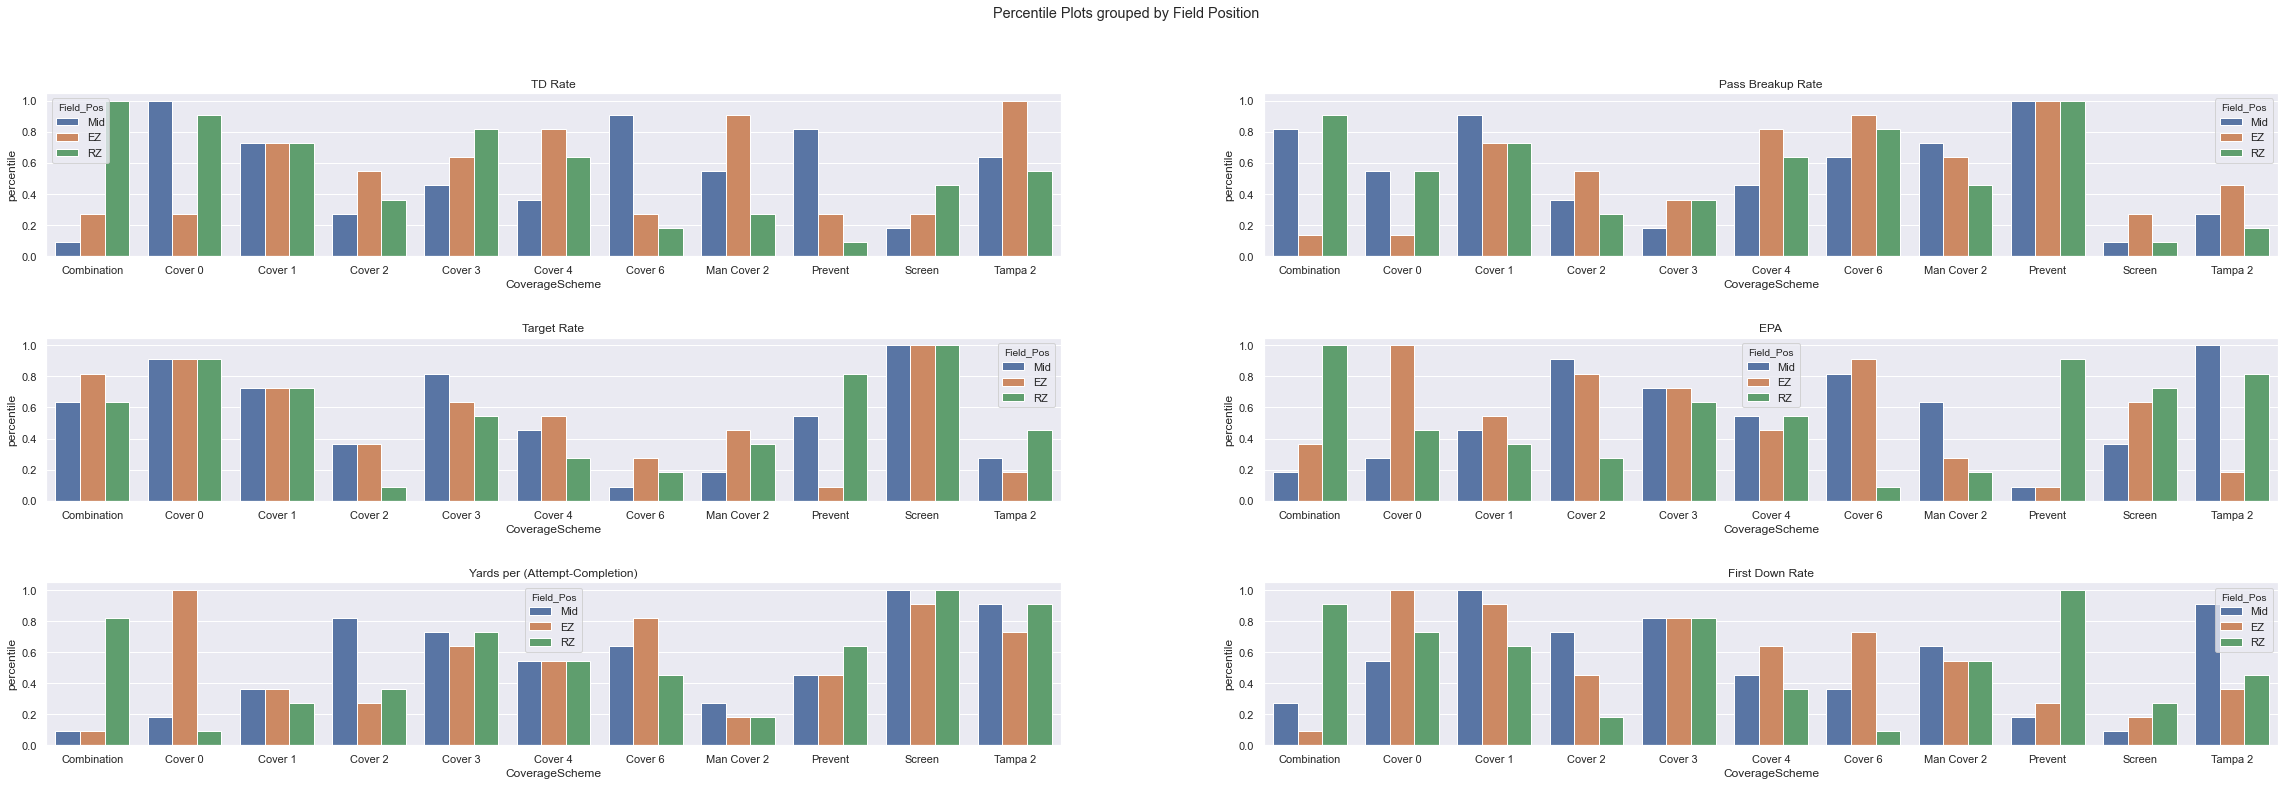

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(40, 12))
fig.suptitle('Percentile Plots grouped by Field Position')

fig.subplots_adjust(hspace=.5)
axes = axes.T.flatten()

sns.barplot(ax=axes[0], data = DF, x='CoverageScheme', y='percentile', hue='Field_Pos')
axes[0].set_title('TD Rate')

sns.barplot(ax=axes[1], data = DF2, x='CoverageScheme', y='percentile', hue='Field_Pos')
axes[1].set_title('Target Rate')

sns.barplot(ax=axes[2], data = DF3, x='CoverageScheme', y='percentile', hue='Field_Pos')
axes[2].set_title('Yards per (Attempt-Completion)')

sns.barplot(ax=axes[3], data = DF4, x='CoverageScheme', y='percentile', hue='Field_Pos')
axes[3].set_title('Pass Breakup Rate')

sns.barplot(ax=axes[4], data = DF5, x='CoverageScheme', y='percentile', hue='Field_Pos')
axes[4].set_title('EPA');

sns.barplot(ax=axes[5], data = DF6, x='CoverageScheme', y='percentile', hue='Field_Pos')
axes[5].set_title('First Down Rate');

# Expected Yards ML Model

A model which uses random forests regression to estimate the expected yardage on a play for a given coverage scheme

In [26]:
def rf_model(key, full_df):
    
    feats = ['PAA', 'DropType_count', 'archetype_count',
                    'pressure_rate_per_coverage','Running_specialized_route',
                    'target_rate_per_coverage',
                    'breakup_rate_per_coverage',
                    'firstdown_rate_per_coverage',
                    'motion_rate_per_coverage', 
                    'YAC_per_cov','Down', 'ToGo','OSRS', 'DSRS','PD',
                  'route_len_count', 'Route_count', 'RosterPosition_count', 'route_len_list_count', 'Route_list_count']
    
    
    X_train, X_test, y_train, y_test = train_test_split(cov_dict[key], 
                                                        cov_dict[key][['OffensiveYardage']], test_size=0.25, random_state=0)
    
    RF= RandomForestRegressor(n_estimators=100,random_state=22)
    
    X_train2 = X_train[feats]
    X_test2 = X_test[feats]

    RF.fit(X_train2,y_train)
    y_pred = RF.predict(X_test2)
    
    print(key)
    print("Train Score:",RF.score(X_train2, y_train))
    print("MAE:",mean_absolute_error(y_pred, y_test))
    print('')
    
    X_test = pd.DataFrame(X_test, columns = X_test.columns)
    X_test.reset_index(inplace=True)
    
    y_pred = pd.DataFrame(y_pred, columns = ['ExpectedYards'])
    df_plot = pd.concat([X_test, y_pred], axis=1)

    return df_plot

In [27]:
df1 = rf_model('Combination', full_df)
df2 = rf_model('Cover 0',  full_df)
df3 = rf_model('Cover 1',  full_df)
df4 = rf_model('Cover 2',  full_df)
df5 = rf_model('Cover 3',  full_df)

df6 = rf_model('Cover 4',  full_df)
df7 = rf_model('Cover 6',  full_df)
df8 = rf_model('Man Cover 2',  full_df)

df9 = rf_model('Prevent',  full_df)
df10 = rf_model('Tampa 2',  full_df)


Combination
Train Score: 0.9924446025495718
MAE: 1.198290598290598

Cover 0
Train Score: 0.9736844666421216
MAE: 1.9410185185185187

Cover 1
Train Score: 0.9665578819994177
MAE: 3.150033379972017

Cover 2
Train Score: 0.9737496530968776
MAE: 2.2709596456692913

Cover 3
Train Score: 0.9644730713600248
MAE: 3.1003817576102057

Cover 4
Train Score: 0.9741941288672643
MAE: 2.507069534472599

Cover 6
Train Score: 0.9791935327112405
MAE: 2.2346263345195734

Man Cover 2
Train Score: 0.9788413329470927
MAE: 2.2328573797678275

Prevent
Train Score: 0.9819274228600616
MAE: 2.495

Tampa 2
Train Score: 0.9776417093821056
MAE: 2.6035714285714286



In [28]:
def plot_results(key, df):
    epa_dict3[key] = epa_dict3[key].reset_index()
    epa_dict2[key] = epa_dict2[key].reset_index()
    epa_dict[key] = epa_dict[key].reset_index()
        
    cond1 = (df.route_len_list ==  epa_dict[key]['route_len_list'][0]) | (df.route_len_list == epa_dict[key]['route_len_list'][1]) | (df.route_len_list ==  epa_dict[key]['route_len_list'][2])
    cond2 = ((df.Route ==  epa_dict2[key]['Route'][0]) |(df.Route ==  epa_dict2[key]['Route'][1]) | (df.Route ==  epa_dict2[key]['Route'][2])) & (df.Running_specialized_route)
    cond3 = (df.Route_list == epa_dict3[key]['Route_list'][0])|(df.Route_list ==epa_dict3[key]['Route_list'][1])|(df.Route_list == epa_dict3[key]['Route_list'][2])
    
    df_plot1 = df[cond1]
    df_plot2 = df[cond2]
    df_plot3 = df[cond3]
    
    return df_plot1,df_plot2,df_plot3

In [29]:
p11, p12, p13 =  plot_results('Cover 0', df2)
p21, p22, p23 =  plot_results('Combination', df1)
p31, p32, p33 =  plot_results('Cover 1', df3)
p41, p42, p43 =  plot_results('Cover 2', df4)
p51, p52, p53 =  plot_results('Cover 3', df5)
p61, p62, p63 =  plot_results('Cover 4', df6)

p71, p72, p73 =  plot_results('Cover 6', df7)
p81, p82, p83 =  plot_results('Man Cover 2', df8)
p91, p92, p93 =  plot_results('Prevent', df9)
px1, px2, px3 =  plot_results('Tampa 2', df10)

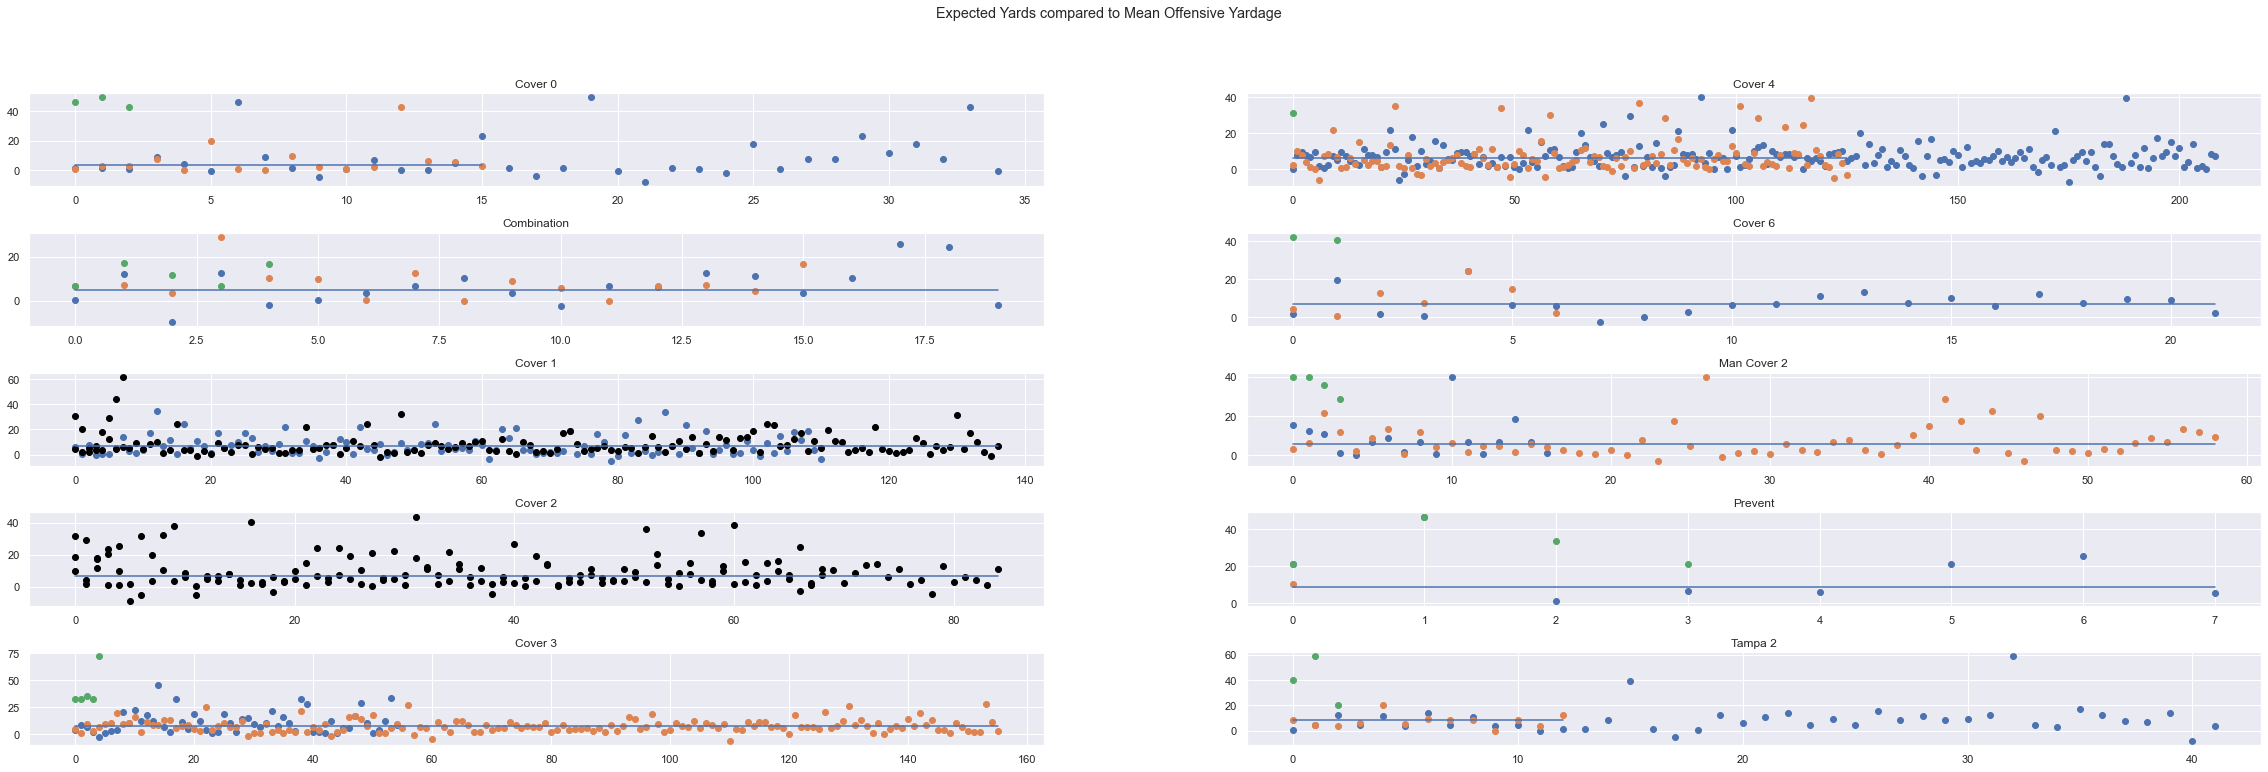

In [30]:
fig, axes = plt.subplots(5, 2, figsize=(40, 12))
fig.suptitle('Expected Yards compared to Mean Offensive Yardage')

fig.subplots_adjust(hspace=.5)
axes = axes.T.flatten()

axes[0].scatter([x for x in range(len(p11))],p11['ExpectedYards'])
axes[0].scatter([x for x in range(len(p12))],p12['ExpectedYards'])
axes[0].scatter([x for x in range(len(p13))],p13['ExpectedYards'])
axes[0].plot([x for x in range(len(p12))], len(p12)*[np.mean(df2['ExpectedYards'])])
axes[0].set_title('Cover 0')

axes[1].scatter([x for x in range(len(p21))],p21['ExpectedYards'])
axes[1].scatter([x for x in range(len(p22))],p22['ExpectedYards'])
axes[1].scatter([x for x in range(len(p23))],p23['ExpectedYards'])
axes[1].plot([x for x in range(len(p21))], len(p21)*[np.mean(df1['ExpectedYards'])])
axes[1].set_title('Combination')

axes[2].scatter([x for x in range(len(p31))],p31['ExpectedYards'])
axes[2].scatter([x for x in range(len(p32))],p32['ExpectedYards'], color = 'black')
axes[2].scatter([x for x in range(len(p33))],p33['ExpectedYards'], color = 'black')
axes[2].plot([x for x in range(len(p32))], len(p32)*[np.mean(df3['ExpectedYards'])])
axes[2].set_title('Cover 1')

axes[3].scatter([x for x in range(len(p41))],p41['ExpectedYards'], color = 'black')
axes[3].scatter([x for x in range(len(p42))],p42['ExpectedYards'], color = 'black')
axes[3].scatter([x for x in range(len(p43))],p43['ExpectedYards'], color = 'black')
axes[3].plot([x for x in range(len(p42))], len(p42)*[np.mean(df4['ExpectedYards'])])
axes[3].set_title('Cover 2')

axes[4].scatter([x for x in range(len(p51))],p51['ExpectedYards'])
axes[4].scatter([x for x in range(len(p52))],p52['ExpectedYards'])
axes[4].scatter([x for x in range(len(p53))],p53['ExpectedYards'])
axes[4].plot([x for x in range(len(p52))], len(p52)*[np.mean(df5['ExpectedYards'])])
axes[4].set_title('Cover 3')

axes[5].scatter([x for x in range(len(p61))],p61['ExpectedYards'])
axes[5].scatter([x for x in range(len(p62))],p62['ExpectedYards'])
axes[5].scatter([x for x in range(len(p63))],p63['ExpectedYards'])
axes[5].plot([x for x in range(len(p62))], len(p62)*[np.mean(df6['ExpectedYards'])])
axes[5].set_title('Cover 4')

axes[6].scatter([x for x in range(len(p71))],p71['ExpectedYards'])
axes[6].scatter([x for x in range(len(p72))],p72['ExpectedYards'])
axes[6].scatter([x for x in range(len(p73))],p73['ExpectedYards'])
axes[6].plot([x for x in range(len(p71))], len(p71)*[np.mean(df7['ExpectedYards'])])
axes[6].set_title('Cover 6')

axes[7].scatter([x for x in range(len(p81))],p81['ExpectedYards'])
axes[7].scatter([x for x in range(len(p82))],p82['ExpectedYards'])
axes[7].scatter([x for x in range(len(p83))],p83['ExpectedYards'])
axes[7].plot([x for x in range(len(p82))], len(p82)*[np.mean(df8['ExpectedYards'])])
axes[7].set_title('Man Cover 2')

axes[8].scatter([x for x in range(len(p91))],p91['ExpectedYards'])
axes[8].scatter([x for x in range(len(p92))],p92['ExpectedYards'])
axes[8].scatter([x for x in range(len(p93))],p93['ExpectedYards'])
axes[8].plot([x for x in range(len(p91))], len(p91)*[np.mean(df9['ExpectedYards'])])
axes[8].set_title('Prevent')

axes[9].scatter([x for x in range(len(px1))],px1['ExpectedYards'])
axes[9].scatter([x for x in range(len(px2))],px2['ExpectedYards'])
axes[9].scatter([x for x in range(len(px3))],px3['ExpectedYards'])
axes[9].plot([x for x in range(len(px2))], len(px2)*[np.mean(df10['ExpectedYards'])])
axes[9].set_title('Tampa 2');

# First Down Prediction ML Model

A model which predicts the probability of a first down on a given play for a given coverage scheme

In [31]:
def log_regress_model(key):
    
    feats = ['pressure_rate_per_coverage','StartYard', 'Hash',
                    'target_rate_per_coverage','archetype_count','DropType_count',
                    'breakup_rate_per_coverage',
                    'firstdown_rate_per_coverage',
                    'motion_rate_per_coverage', 
                    'YAC_per_cov','Down', 'ToGo','OSRS', 'DSRS','PD',
                  'PAA', 'route_len_count', 'Route_count', 
                    'PressureOnPlay','RPO', 'Shotgun', 'ThrowDepth','Running_specialized_route', 'route_len_list_count', 'Route_list_count']
    
    X = cov_dict[key]
    
    X_train, X_test, y_train, y_test = train_test_split(X, cov_dict[key][['FirstDown']], test_size=0.25, random_state=0)
    
    scaler = MinMaxScaler(feature_range = (0,1))
    
    X_train2 = X_train[feats]
    X_test2 = X_test[feats]

    scaler.fit(X_train2)
    X_train2 = scaler.transform(X_train2)
    X_test2 = scaler.transform(X_test2)
    
    clf = DecisionTreeClassifier(class_weight = 'balanced').fit(X_train2, y_train)
    print(key)
    print(' ')
    print('Train Score: ' + str(clf.score(X_train2, y_train)))
    
    y_pred = clf.predict(X_test2)
    
    cm = confusion_matrix(y_test, y_pred)

    print('Balanced Accuracy: ' + str(100*balanced_accuracy_score(y_pred, y_test)) + '%')
    print('Accuracy: ' + str(100*accuracy_score(y_pred, y_test)) + '%')
    print(' ')
    print('Confusion Matrix:')
    print(cm)
    print(' ')
    
    probs = pd.DataFrame(clf.predict_proba(X_test2), columns = ['Probability_No_First_down', 'Probability_First_down'])
    X_test = pd.DataFrame(X_test)
    
    probs_with_feats = X_test.merge(probs, on = X_test.index)

    return probs_with_feats 


In [32]:
probs = log_regress_model('Combination')
probs2 = log_regress_model('Cover 0')
probs3 = log_regress_model('Cover 1')
probs4= log_regress_model('Cover 2')
probs5 = log_regress_model('Cover 3')
probs6 = log_regress_model('Cover 4')
probs7 = log_regress_model('Cover 6')
probs8 = log_regress_model('Man Cover 2')
probs9 = log_regress_model('Prevent')
probs10 = log_regress_model('Tampa 2')

Combination
 
Train Score: 1.0
Balanced Accuracy: 97.43589743589743%
Accuracy: 96.58119658119658%
 
Confusion Matrix:
[[74  0]
 [ 4 39]]
 
Cover 0
 
Train Score: 1.0
Balanced Accuracy: 96.04885057471265%
Accuracy: 96.11111111111111%
 
Confusion Matrix:
[[335   8]
 [ 13 184]]
 
Cover 1
 
Train Score: 1.0
Balanced Accuracy: 98.0624510082171%
Accuracy: 98.18109134519288%
 
Confusion Matrix:
[[3039   47]
 [  44 1873]]
 
Cover 2
 
Train Score: 1.0
Balanced Accuracy: 99.15648706641662%
Accuracy: 99.31102362204724%
 
Confusion Matrix:
[[1304   10]
 [   4  714]]
 
Cover 3
 
Train Score: 1.0
Balanced Accuracy: 98.43487616062868%
Accuracy: 98.5079575596817%
 
Confusion Matrix:
[[3836   39]
 [  51 2106]]
 
Cover 4
 
Train Score: 1.0
Balanced Accuracy: 98.10516402321709%
Accuracy: 98.35002946375958%
 
Confusion Matrix:
[[2305   27]
 [  29 1033]]
 
Cover 6
 
Train Score: 1.0
Balanced Accuracy: 100.0%
Accuracy: 100.0%
 
Confusion Matrix:
[[394   0]
 [  0 168]]
 
Man Cover 2
 
Train Score: 1.0
Balanc

In [33]:
def plot_results2(key, df):

    cond1 = (df.route_len_list ==  epa_dict[key]['route_len_list'][0]) | (df.route_len_list == epa_dict[key]['route_len_list'][1]) | (df.route_len_list ==  epa_dict[key]['route_len_list'][2])
    cond2 = ((df.Route ==  epa_dict2[key]['Route'][0]) |(df.Route ==  epa_dict2[key]['Route'][1]) | (df.Route ==  epa_dict2[key]['Route'][2])) & (df.Running_specialized_route)
    cond3 = (df.Route_list == epa_dict3[key]['Route_list'][0])|(df.Route_list ==epa_dict3[key]['Route_list'][1])|(df.Route_list == epa_dict3[key]['Route_list'][2])
    
    df_plot1 = df[cond1]
    df_plot2 = df[cond2]
    df_plot3 = df[cond3]
    
    return df_plot1,df_plot2,df_plot3

In [34]:
p11, p12, p13 =  plot_results('Combination', probs)
p21, p22, p23 =  plot_results('Cover 0', probs2)
p31, p32, p33 =  plot_results('Cover 1', probs3)
p41, p42, p43 =  plot_results('Cover 2', probs4)
p51, p52, p53 =  plot_results('Cover 3', probs5)
p61, p62, p63 =  plot_results('Cover 4', probs6)

p71, p72, p73 =  plot_results('Cover 6', probs7)
p81, p82, p83 =  plot_results('Man Cover 2', probs8)
p91, p92, p93 =  plot_results('Prevent', probs9)
px1, px2, px3 =  plot_results('Tampa 2', probs10)

In [35]:
tot1 = (p11['Probability_First_down'] == 1).sum() + (p12['Probability_First_down'] == 1).sum() + (p13['Probability_First_down'] == 1).sum() + (p11['Probability_First_down'] == 0).sum() + (p12['Probability_First_down'] == 0).sum() + (p13['Probability_First_down'] == 0).sum()
p1_1 = ((p11['Probability_First_down'] == 1).sum() + (p12['Probability_First_down'] == 1).sum() + (p13['Probability_First_down'] == 1).sum())/tot1
p1_0 = ((p11['Probability_First_down'] == 0).sum() + (p12['Probability_First_down'] == 0).sum() + (p13['Probability_First_down'] == 0).sum())/tot1
p1m = (probs['Probability_First_down'] == 1).sum()/((probs['Probability_First_down'] == 1).sum() + (probs['Probability_First_down'] == 0).sum())

tot2 = (p21['Probability_First_down'] == 1).sum() + (p22['Probability_First_down'] == 1).sum() + (p23['Probability_First_down'] == 1).sum() + (p21['Probability_First_down'] == 0).sum() + (p22['Probability_First_down'] == 0).sum() + (p23['Probability_First_down'] == 0).sum()
p2_1 = ((p21['Probability_First_down'] == 1).sum() + (p22['Probability_First_down'] == 1).sum() + (p23['Probability_First_down'] == 1).sum())/tot2
p2_0 = ((p21['Probability_First_down'] == 0).sum() + (p22['Probability_First_down'] == 0).sum() + (p23['Probability_First_down'] == 0).sum())/tot2
p2m = (probs2['Probability_First_down'] == 1).sum()/((probs2['Probability_First_down'] == 1).sum() + (probs2['Probability_First_down'] == 0).sum())

tot3 = (p31['Probability_First_down'] == 1).sum() + (p32['Probability_First_down'] == 1).sum() + (p33['Probability_First_down'] == 1).sum() + (p31['Probability_First_down'] == 0).sum() + (p32['Probability_First_down'] == 0).sum() + (p33['Probability_First_down'] == 0).sum()
p3_1 = ((p31['Probability_First_down'] == 1).sum() + (p32['Probability_First_down'] == 1).sum() + (p33['Probability_First_down'] == 1).sum())/tot3
p3_0 = ((p31['Probability_First_down'] == 0).sum() + (p32['Probability_First_down'] == 0).sum() + (p33['Probability_First_down'] == 0).sum())/tot3
p3m = (probs3['Probability_First_down'] == 1).sum()/((probs3['Probability_First_down'] == 1).sum() + (probs3['Probability_First_down'] == 0).sum())

tot4 = (p41['Probability_First_down'] == 1).sum() + (p42['Probability_First_down'] == 1).sum() + (p43['Probability_First_down'] == 1).sum() + (p41['Probability_First_down'] == 0).sum() + (p42['Probability_First_down'] == 0).sum() + (p43['Probability_First_down'] == 0).sum()
p4_1 = ((p41['Probability_First_down'] == 1).sum() + (p42['Probability_First_down'] == 1).sum() + (p43['Probability_First_down'] == 1).sum())/tot4
p4_0 = ((p41['Probability_First_down'] == 0).sum() + (p42['Probability_First_down'] == 0).sum() + (p43['Probability_First_down'] == 0).sum())/tot4
p4m = (probs4['Probability_First_down'] == 1).sum()/((probs4['Probability_First_down'] == 1).sum() + (probs4['Probability_First_down'] == 0).sum())

tot5 = (p51['Probability_First_down'] == 1).sum() + (p52['Probability_First_down'] == 1).sum() + (p53['Probability_First_down'] == 1).sum() + (p51['Probability_First_down'] == 0).sum() + (p52['Probability_First_down'] == 0).sum() + (p53['Probability_First_down'] == 0).sum()
p5_1 = ((p51['Probability_First_down'] == 1).sum() + (p52['Probability_First_down'] == 1).sum() + (p53['Probability_First_down'] == 1).sum())/tot5
p5_0 = ((p51['Probability_First_down'] == 0).sum() + (p52['Probability_First_down'] == 0).sum() + (p53['Probability_First_down'] == 0).sum())/tot5
p5m = (probs5['Probability_First_down'] == 1).sum()/((probs5['Probability_First_down'] == 1).sum() + (probs5['Probability_First_down'] == 0).sum())

tot6 = (p61['Probability_First_down'] == 1).sum() + (p62['Probability_First_down'] == 1).sum() + (p63['Probability_First_down'] == 1).sum() + (p61['Probability_First_down'] == 0).sum() + (p62['Probability_First_down'] == 0).sum() + (p63['Probability_First_down'] == 0).sum()
p6_1 = ((p61['Probability_First_down'] == 1).sum() + (p62['Probability_First_down'] == 1).sum() + (p63['Probability_First_down'] == 1).sum())/tot6
p6_0 = ((p61['Probability_First_down'] == 0).sum() + (p62['Probability_First_down'] == 0).sum() + (p63['Probability_First_down'] == 0).sum())/tot6
p6m = (probs6['Probability_First_down'] == 1).sum()/((probs6['Probability_First_down'] == 1).sum() + (probs6['Probability_First_down'] == 0).sum())

tot7 = (p71['Probability_First_down'] == 1).sum() + (p72['Probability_First_down'] == 1).sum() + (p73['Probability_First_down'] == 1).sum() + (p71['Probability_First_down'] == 0).sum() + (p72['Probability_First_down'] == 0).sum() + (p73['Probability_First_down'] == 0).sum()
p7_1 = ((p71['Probability_First_down'] == 1).sum() + (p72['Probability_First_down'] == 1).sum() + (p73['Probability_First_down'] == 1).sum())/tot7
p7_0 = ((p71['Probability_First_down'] == 0).sum() + (p72['Probability_First_down'] == 0).sum() + (p73['Probability_First_down'] == 0).sum())/tot7
p7m = (probs7['Probability_First_down'] == 1).sum()/((probs7['Probability_First_down'] == 1).sum() + (probs7['Probability_First_down'] == 0).sum())

tot8 = (p81['Probability_First_down'] == 1).sum() + (p82['Probability_First_down'] == 1).sum() + (p83['Probability_First_down'] == 1).sum() + (p81['Probability_First_down'] == 0).sum() + (p82['Probability_First_down'] == 0).sum() + (p83['Probability_First_down'] == 0).sum()
p8_1 = ((p81['Probability_First_down'] == 1).sum() + (p82['Probability_First_down'] == 1).sum() + (p83['Probability_First_down'] == 1).sum())/tot8
p8_0 = ((p81['Probability_First_down'] == 0).sum() + (p82['Probability_First_down'] == 0).sum() + (p83['Probability_First_down'] == 0).sum())/tot8
p8m = (probs8['Probability_First_down'] == 1).sum()/((probs8['Probability_First_down'] == 1).sum() + (probs8['Probability_First_down'] == 0).sum())

tot9 = (p91['Probability_First_down'] == 1).sum() + (p92['Probability_First_down'] == 1).sum() + (p93['Probability_First_down'] == 1).sum() + (p91['Probability_First_down'] == 0).sum() + (p92['Probability_First_down'] == 0).sum() + (p93['Probability_First_down'] == 0).sum()
p9_1 = ((p91['Probability_First_down'] == 1).sum() + (p92['Probability_First_down'] == 1).sum() + (p93['Probability_First_down'] == 1).sum())/tot9
p9_0 = ((p91['Probability_First_down'] == 0).sum() + (p92['Probability_First_down'] == 0).sum() + (p93['Probability_First_down'] == 0).sum())/tot9
p9m = (probs9['Probability_First_down'] == 1).sum()/((probs9['Probability_First_down'] == 1).sum() + (probs9['Probability_First_down'] == 0).sum())


totx = (px1['Probability_First_down'] == 1).sum() + (px2['Probability_First_down'] == 1).sum() + (px3['Probability_First_down'] == 1).sum() + (px1['Probability_First_down'] == 0).sum() + (px2['Probability_First_down'] == 0).sum() + (px3['Probability_First_down'] == 0).sum()
px_1 = ((px1['Probability_First_down'] == 1).sum() + (px2['Probability_First_down'] == 1).sum() + (px3['Probability_First_down'] == 1).sum())/totx
px_0 = ((px1['Probability_First_down'] == 0).sum() + (px2['Probability_First_down'] == 0).sum() + (px3['Probability_First_down'] == 0).sum())/totx
pxm = (probs10['Probability_First_down'] == 1).sum()/((probs10['Probability_First_down'] == 1).sum() + (probs10['Probability_First_down'] == 0).sum())

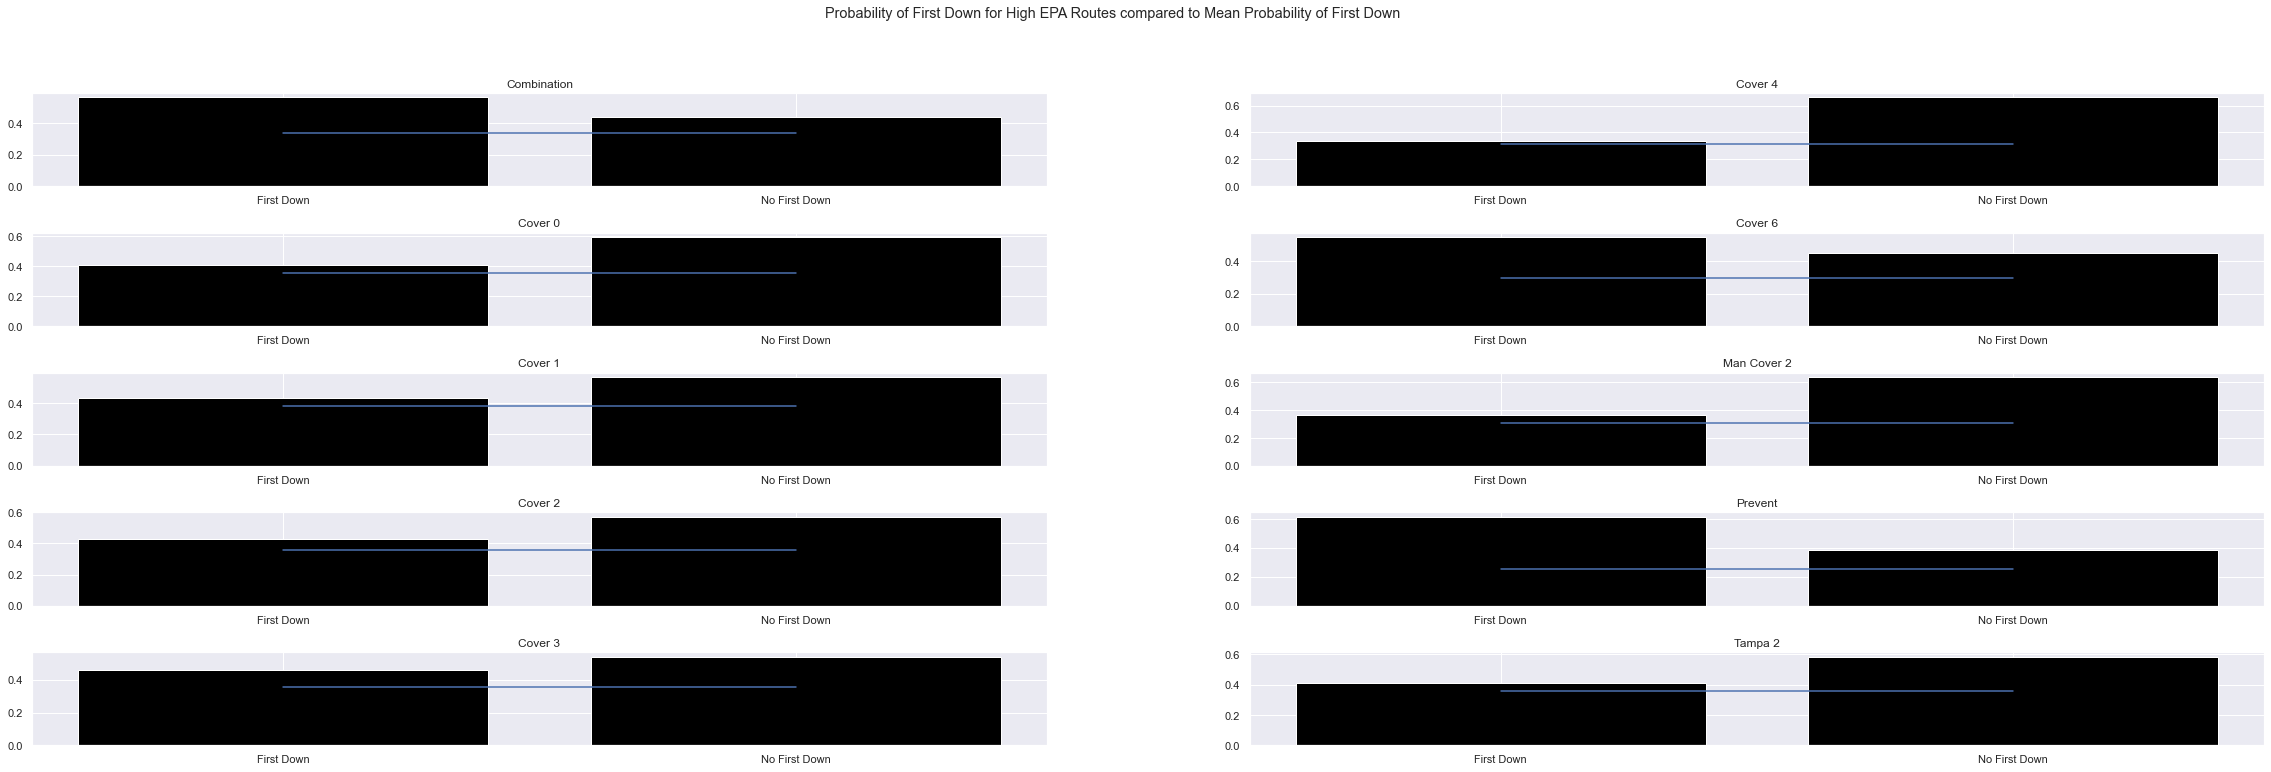

In [36]:
fig, axes = plt.subplots(5, 2, figsize=(40, 12))
fig.suptitle('Probability of First Down for High EPA Routes compared to Mean Probability of First Down')

fig.subplots_adjust(hspace=.5)
axes = axes.T.flatten()

axes[0].bar('First Down', p1_1, color = 'black')
axes[0].bar('No First Down',p1_0, color = 'black')
axes[0].plot([0,1], 2*[p1m])
axes[0].set_title('Combination')

axes[1].bar('First Down', p2_1, color = 'black')
axes[1].bar('No First Down',p2_0, color = 'black')
axes[1].plot([0,1], 2*[p2m])
axes[1].set_title('Cover 0')

axes[2].bar('First Down', p3_1, color = 'black')
axes[2].bar('No First Down',p3_0, color = 'black')
axes[2].plot([0,1], 2*[p3m])
axes[2].set_title('Cover 1')

axes[3].bar('First Down', p4_1, color = 'black')
axes[3].bar('No First Down',p4_0, color = 'black')
axes[3].plot([0,1], 2*[p4m])
axes[3].set_title('Cover 2')

axes[4].bar('First Down', p5_1, color = 'black')
axes[4].bar('No First Down',p5_0, color = 'black')
axes[4].plot([0,1], 2*[p5m])
axes[4].set_title('Cover 3')

axes[5].bar('First Down', p6_1, color = 'black')
axes[5].bar('No First Down',p6_0, color = 'black')
axes[5].plot([0,1], 2*[p6m])
axes[5].set_title('Cover 4')

axes[6].bar('First Down', p7_1, color = 'black')
axes[6].bar('No First Down',p7_0, color = 'black')
axes[6].plot([0,1], 2*[p7m])
axes[6].set_title('Cover 6')

axes[7].bar('First Down', p8_1, color = 'black')
axes[7].bar('No First Down',p8_0, color = 'black')
axes[7].plot([0,1], 2*[p8m])
axes[7].set_title('Man Cover 2')

axes[8].bar('First Down', p9_1, color = 'black')
axes[8].bar('No First Down',p9_0, color = 'black')
axes[8].plot([0,1], 2*[p9m])
axes[8].set_title('Prevent')

axes[9].bar('First Down', px_1, color = 'black')
axes[9].bar('No First Down',px_0, color = 'black')
axes[9].plot([0,1], 2*[pxm])
axes[9].set_title('Tampa 2');

# END